Here we develop code to fit latent regression models to data with priors on the projection matrices

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from janelia_core.ml.extra_torch_modules import Bias
from janelia_core.ml.extra_torch_modules import ConstantBoundedFcn
from janelia_core.ml.extra_torch_modules import IndSmpConstantBoundedFcn
from janelia_core.ml.extra_torch_modules import IndSmpConstantRealFcn
from janelia_core.ml.extra_torch_modules import LogGaussianBumpFcn

from janelia_core.ml.latent_regression import LatentRegModel
from janelia_core.ml.latent_regression import LinearMap
from janelia_core.ml.latent_regression import IdentityMap
from janelia_core.ml.latent_regression import vae_fit_latent_reg_model

from janelia_core.ml.torch_distributions import CondBernoulliDistribution
from janelia_core.ml.torch_distributions import CondGaussianDistribution
from janelia_core.ml.torch_distributions import CondSpikeSlabDistribution

from janelia_core.visualization.matrix_visualization import cmp_n_mats

## Parameters go here

In [3]:
n_neurons = [1000]

d_in = n_neurons
d_out = n_neurons

d_proj = [2]
d_trans = [2]

n_smps = 100

device = 'cpu' # Device to perform fitting on

## Helper functions for visualization

In [4]:
def visualize_mode_mean(d, x_range = [0.0, 1.0], y_range = [0.0, 1.0], n_points_per_side=100):

    d = d.to('cpu') # Make a copy of model on cpu
    
    grid = np.mgrid[x_range[0]:x_range[1]:n_points_per_side * 1j,
           y_range[0]:y_range[1]:n_points_per_side * 1j]

    grid_vec = np.stack([np.ravel(grid[0, :, :]), np.ravel(grid[1, :, :])]).transpose()
    grid_vec = torch.from_numpy(grid_vec.astype('float32'))

    mn_vec = d(grid_vec).detach().numpy()
    mn_image = np.reshape(mn_vec, [n_points_per_side, n_points_per_side])
    
    plt.imshow(mn_image, extent=[x_range[0], x_range[1], y_range[0], y_range[1]], origin='lower')
    plt.colorbar()
    
    #d = d.to('cuda')

def visualize_mode_pairs(d1, d2, x_range = [0.0, 1.0], y_range = [0.0, 1.0], n_points_per_side=100):
      
    n_modes = len(d1)    
    
    plt.figure()
    
    for m_i in range(n_modes):
            
        # Plot d1 modes in top row
        plt.subplot(2, n_modes, m_i+1)
        visualize_mode_mean(d1[m_i], x_range=x_range, y_range=y_range, n_points_per_side=n_points_per_side)
        
        # Plot d2 modes in second row
        plt.subplot(2, n_modes, m_i+1 + n_modes)
        visualize_mode_mean(d2[m_i], x_range=x_range, y_range=y_range, n_points_per_side=n_points_per_side)

## Define the true conditional priors on mode weights

In [5]:
n_grps = len(n_neurons)

In [6]:
# Spike and slab modes

n_prior_nodes = 20

true_prior_p_dists = [None]*n_grps
true_prior_u_dists = [None]*n_grps

for g in range(n_grps):

    n_grp_modes = [d_proj[g], d_trans[g]]
    for i in range(2):
        # Iterate over p and u modes
        n_cur_modes = n_grp_modes[i]
        proj_mode_dists = [None]*n_cur_modes
        for mode_i in range(n_cur_modes):
            
            spike_log_prob_fcn = LogGaussianBumpFcn(d_x=2, ctr_std_init=0.25, log_gain_init=-0.00001)
            spike_d = CondBernoulliDistribution(spike_log_prob_fcn)
            
            slab_mn_fcn = torch.nn.Sequential(torch.nn.Linear(2,n_prior_nodes), torch.nn.ReLU(), 
                                              torch.nn.Linear(n_prior_nodes, n_prior_nodes), torch.nn.ReLU(), 
                                              torch.nn.Linear(n_prior_nodes,1))
            slab_mn_fcn[4].weight.data = 10*slab_mn_fcn[4].weight.data
            
            slab_std_fcn = ConstantBoundedFcn(lower_bound=np.asarray([.001]), upper_bound=np.asarray([10]), 
                                        init_value=np.asarray(.01))
            
            slab_d = CondGaussianDistribution(mn_f=slab_mn_fcn, std_f=slab_std_fcn)
    
            proj_mode_dists[mode_i] = CondSpikeSlabDistribution(d=1, spike_d=spike_d, slab_d=slab_d)
        
        if i == 0:
            true_prior_p_dists[g] = proj_mode_dists
        else:
            true_prior_u_dists[g] = proj_mode_dists

In [7]:
# Group the true priors by group (so that distributions for p and u modes are together) for convenience
true_prior_mode_dists = list(zip(true_prior_p_dists, true_prior_u_dists))

## Generate neuron properties

In [8]:
neuron_props = [torch.zeros(n_neurons[g], 2).uniform_() for g in range(n_grps)]

## Generate true mode weights from the prior that was just defined 

In [9]:
true_p = [None]*n_grps
true_u = [None]*n_grps

for g in range(n_grps):
    n_grp_neurons = n_neurons[g]
    n_grp_modes = [d_proj[g], d_trans[g]]
    
    for i in range(2):
        n_cur_modes = n_grp_modes[i]
        mode_mat = torch.zeros(n_grp_neurons, n_cur_modes)
        for mode_i in range(n_cur_modes):
            mode_mat[:, mode_i] = true_prior_mode_dists[g][i][mode_i].form_standard_sample(
                true_prior_mode_dists[g][i][mode_i].sample(neuron_props[g])).squeeze()
        if i == 0:
            # P modes
            true_p[g] = mode_mat
        else:
            # U modes
            true_u[g] = mode_mat

# Define the true subject model

In [10]:
n_output_groups = len(d_in)

M = IdentityMap()
S = [Bias(d_o) for d_o in d_out]
mdl = LatentRegModel(d_in, d_out, d_proj, d_trans, M, S, direct_pairs=None, noise_range=[.25, .255])

for g, p_g in enumerate(mdl.p):
    p_g.data = true_p[g]
for h, u_h in enumerate(mdl.u):
    u_h.data = true_u[h]

## Generate data

In [11]:
x = [torch.randn([n_smps, d]) for d in d_in]
y_pred = mdl(x)
y = mdl.generate(x)

## Define the subject model we will fit

In [12]:
m_f = IdentityMap()
s_f = [Bias(d_o) for d_o in d_out]
subject_mdl_f = LatentRegModel(d_in, d_out, d_proj, d_trans, m_f, s_f, direct_pairs=None, assign_p_u=False)
subject_mdl_f = subject_mdl_f.to(device)

## Define the inference distribution (  $Q(l, r)$  ) that we will use

In [13]:
q_p_mode_dists = [None]*n_grps
q_u_mode_dists = [None]*n_grps

for g in range(n_grps):
    n_grp_neurons = n_neurons[g]
    for i in range(2):
        if i == 0:
            n_grp_modes = d_proj[g]
        else:
            n_grp_modes = d_trans[g]
    
        q_dists = [None]*n_grp_modes
        
        for mode_i in range(n_grp_modes):
            mn_f = IndSmpConstantRealFcn(n_grp_neurons, init_value=.01)
            std_f = IndSmpConstantBoundedFcn(n_grp_neurons, lower_bound=.0001, upper_bound=10.0, init_value=.2)
            q_dists[mode_i] = CondGaussianDistribution(mn_f=mn_f, std_f=std_f)
            q_dists[mode_i] = q_dists[mode_i].to(device)
        
        if i == 0:
            q_p_mode_dists[g] = q_dists
        else:
            q_u_mode_dists[g] = q_dists

## Define the conditional prior distribution (  $P(l,r|m)$  ) we will fit

In [14]:
class ExpModule(torch.nn.Module):
    def forward(self, x):
        return torch.exp(x) + .01

In [22]:
n_fit_prior_nodes = 100
n_fit_std_prior_nodes = 100

prior_p_dists = [None]*n_grps
prior_u_dists = [None]*n_grps

for g in range(n_grps):
    n_grp_neurons = n_neurons[g]
    for i in range(2):
        if i == 0:
            n_grp_modes = d_proj[g]
        else:
            n_grp_modes = d_trans[g]
            
        prior_dists = [None]*n_grp_modes
        
        for mode_i in range(n_grp_modes):
            mn_fcn = torch.nn.Sequential(torch.nn.Linear(2,n_fit_prior_nodes), torch.nn.ReLU(), 
                                              torch.nn.Linear(n_fit_prior_nodes, n_fit_prior_nodes), torch.nn.ReLU(), 
                                              torch.nn.Linear(n_fit_prior_nodes,1))
            mn_fcn[4].weight.data = 10*mn_fcn[4].weight.data
            
            #std_fcn = torch.nn.Sequential(torch.nn.Linear(2,n_fit_std_prior_nodes), torch.nn.ReLU(), 
             #                                 torch.nn.Linear(n_fit_std_prior_nodes, n_fit_std_prior_nodes), torch.nn.ReLU(), 
             #                                 torch.nn.Linear(n_fit_std_prior_nodes,1), ExpModule())
            
            std_fcn = ConstantBoundedFcn(lower_bound=np.asarray([.001]), upper_bound=np.asarray([10]), 
                                        init_value=np.asarray(.01))
            
            prior_dists[mode_i] = CondGaussianDistribution(mn_f=mn_fcn, std_f=std_fcn)
            prior_dists[mode_i] = prior_dists[mode_i].to(device)
        
        if i == 0:
            prior_p_dists[g] = prior_dists
        else:
            prior_u_dists[g] = prior_dists

## Fit everything with variational inference

In [43]:
log = vae_fit_latent_reg_model(l_mdl = subject_mdl_f, q_p_dists=q_p_mode_dists, q_u_dists=q_u_mode_dists, 
                             prior_p_dists=prior_p_dists, prior_u_dists=prior_u_dists, learning_rates = .02,
                             x=x, y=y, x_props=neuron_props, batch_size = 100, send_size = 100, update_int=200, 
                             max_its=1000, min_var=.00001)

It: 0: Elapsed fitting time 1.0967254638671875e-05, elbo: -86237.97888183594, lr: 0.02, GPU mem. usage: nan bytes
    ll: -76861.265625, kl_p_sum: 2898.6219482421875, kl_u_sum: 6478.09130859375
It: 200: Elapsed fitting time 2.5805859565734863, elbo: -86915.43286132812, lr: 0.02, GPU mem. usage: nan bytes
    ll: -77210.75, kl_p_sum: 3275.079833984375, kl_u_sum: 6429.60302734375
It: 400: Elapsed fitting time 5.035171985626221, elbo: -87203.98791503906, lr: 0.02, GPU mem. usage: nan bytes
    ll: -77660.9296875, kl_p_sum: 3070.7083740234375, kl_u_sum: 6472.349853515625
It: 600: Elapsed fitting time 7.510724067687988, elbo: -86528.13879394531, lr: 0.02, GPU mem. usage: nan bytes
    ll: -77055.4140625, kl_p_sum: 3009.8778076171875, kl_u_sum: 6462.846923828125
It: 800: Elapsed fitting time 9.983059167861938, elbo: -86852.91015625, lr: 0.02, GPU mem. usage: nan bytes
    ll: -77676.3203125, kl_p_sum: 2824.23095703125, kl_u_sum: 6352.35888671875
It: 999: Elapsed fitting time 12.5063459873199

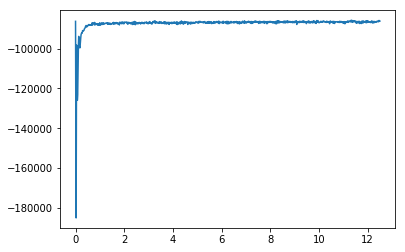

In [44]:
plt.plot(log['elapsed_time'], log['elbo'])

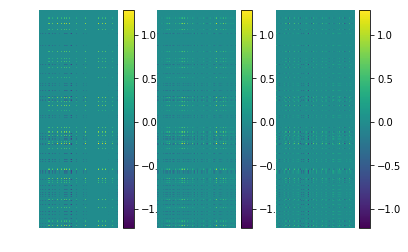

In [45]:
vis_g = 0

true_w = torch.matmul(true_u[vis_g], true_p[vis_g].t()).detach().numpy()

est_p = [d.sample(neuron_props[vis_g]) for d in q_p_mode_dists[vis_g]]
est_p = torch.cat(est_p, dim=1)

est_u = [d.sample(neuron_props[vis_g]) for d in q_u_mode_dists[vis_g]]
est_u = torch.cat(est_u, dim=1)

est_w = torch.matmul(est_u, est_p.t()).detach().cpu().numpy()

cmp_n_mats([true_w, est_w, true_w-est_w], show_colorbars=True)


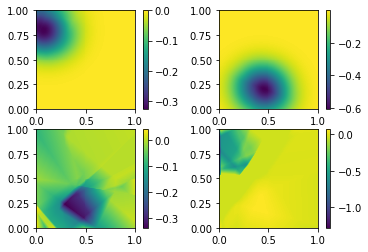

In [46]:
visualize_mode_pairs(true_prior_u_dists[vis_g], prior_u_dists[vis_g])

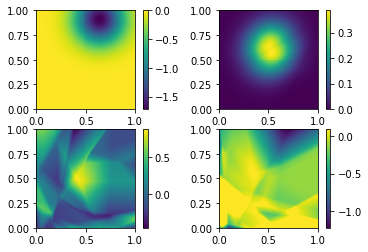

In [47]:
visualize_mode_pairs(true_prior_p_dists[vis_g], prior_p_dists[vis_g])

In [ ]:
prior_p_dists[0][1].std_f(neuron_props[0])